In [1]:
# IMPORT LIBRARIES
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
from datetime import datetime

# LOAD CSV FILES
df_train = pd.read_csv('./sample_train_removed_features.csv') #, usecols=dtypes.keys(), dtype=dtypes)
print ('Loaded',len(df_train),'rows of TRAIN.CSV!')
df_test = pd.read_csv('./sample_test_removed_features.csv') #, usecols=list(dtypes.keys())[0:-1], dtype=dtypes)
print ('Loaded',len(df_test),'rows of TEST.CSV!')

/Users/stathis/anaconda3/envs/dme/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded 2230371 rows of TRAIN.CSV!
Loaded 334556 rows of TEST.CSV!


In [2]:
import calendar, math

In [3]:
# CHECK FOR NAN
def nan_check(x):
    if isinstance(x,float):
        if math.isnan(x):
            return True
    return False

# INCREMENT A DATETIME
def add_time(sdate,months=0,days=0,hours=0):
    month = sdate.month -1 + months
    year = sdate.year + month // 12
    month = month % 12 + 1
    day = sdate.day + days
    if day>calendar.monthrange(year,month)[1]:
        day -= calendar.monthrange(year,month)[1]
        month += 1
        if month>12:
            month = 1
            year += 1
    hour = sdate.hour + hours
    if hour>23:
        hour = 0
        day += 1
        if day>calendar.monthrange(year,month)[1]:
            day -= calendar.monthrange(year,month)[1]
            month += 1
            if month>12:
                month = 1
                year += 1
    return datetime(year,month,day)

In [4]:
# IMPORT TIMESTAMP DICTIONARY
datedict = np.load('./AvSigVersionTimestamps.npy')
datedict = datedict[()]
# ADD TIMESTAMPS
df_train['Date'] = df_train['AvSigVersion'].map(datedict)
df_test['Date'] = df_test['AvSigVersion'].map(datedict)
df_train['ones'] = 1; df_test['ones'] = 1

In [5]:
def get_data(data):
    col='ones'
    target='HasDetections'
    start=datetime(2018,6,1)
    end=datetime(2018,11,1)
    inc_hr=0
    inc_dy=7
    inc_mn=0
    show=0.99
    top=5
    top2=4
    title=''
    legend=1
    dropna=False

    # remove detection line if category density is too small
    cv = data[col].value_counts(dropna=dropna)
    cvd = cv.to_dict()
    nm = cv.index.values
    th = show * len(data)
    sum = 0; lnn2 = 0
    for x in nm:
        lnn2 += 1
        try: sum += cvd[x]
        except: sum += cv[x]
        if sum>th:
            break
    top = min(top,len(nm))
    top2 = min(top2,len(nm),lnn2,top)

    # calculate rate within each time interval
    diff = (end-start).days*24*3600 + (end-start).seconds
    size = diff//(3600*((inc_mn * 28 + inc_dy) * 24 + inc_hr)) + 5
    data_counts = np.zeros([size,2*top+1],dtype=float)
    idx=0; idx2 = {}
    for i in range(top):
        idx2[nm[i]] = i+1
    low = start
    high = add_time(start,inc_mn,inc_dy,inc_hr)
    data_times = [low+(high-low)/2]
    while low<end:
        slice = data[ (data['Date']<high) & (data['Date']>=low) ]
        data_counts[idx,0] = len(slice)
        for key in idx2:
            if nan_check(key): slice2 = slice[slice[col].isna()]
            else: slice2 = slice[slice[col]==key]
            data_counts[idx,idx2[key]] = len(slice2)
            if target in data:
                data_counts[idx,top+idx2[key]] = slice2['HasDetections'].mean()
        low = high
        high = add_time(high,inc_mn,inc_dy,inc_hr)
        data_times.append(low+(high-low)/2)
        idx += 1
    print(idx)
    return data_counts, data_times

In [7]:
idx=22

In [8]:
data_counts_train, data_times_train = get_data(df_train)
data_counts_train = np.array(data_counts_train)
data_counts_train[0:idx+1,1] /= np.sum(data_counts_train[0:idx+1,1])

data_counts_test, data_times_test = get_data(df_test)
data_counts_test = np.array(data_counts_test)
data_counts_test[0:idx+1,1] /= np.sum(data_counts_test[0:idx+1,1])

22
22


In [9]:
len(data_times_train)

23

In [10]:
len(data_counts_train)

26

In [11]:
plt.style.use('ggplot')

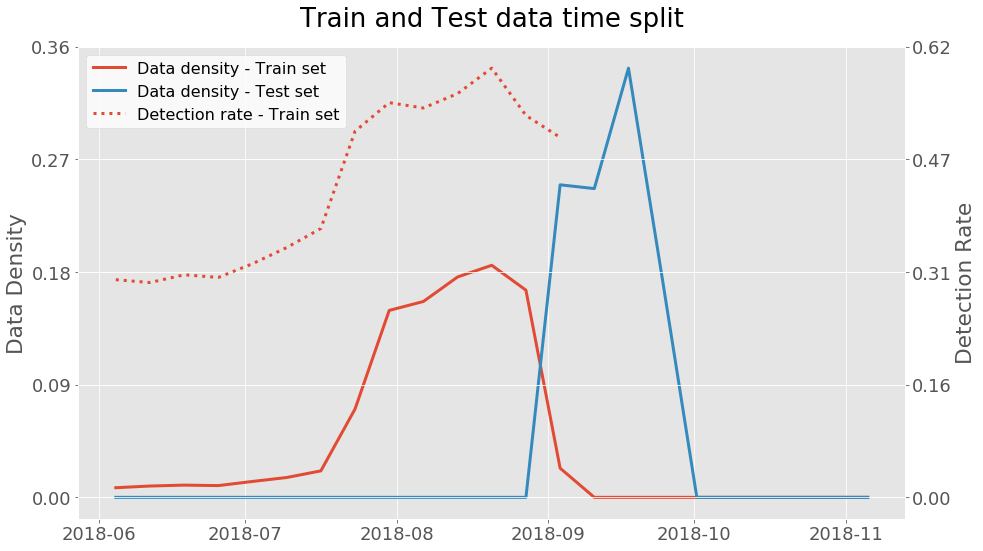

In [39]:
# plot lines
fig = plt.figure(figsize=(14,8))
cl = ['r','g','b','y','m']
ax3 = fig.add_subplot(1,1,1)

lns1 = ax3.plot(data_times_train,data_counts_train[0:idx+1,1], label='Data density - Train set', linewidth=3)
lns2 = ax3.plot(data_times_test,data_counts_test[0:idx+1,1], label='Data density - Test set', linewidth=3)
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y%M')
ax3.xaxis.set_major_formatter(yearsFmt)
ax3.set_ylabel('Data Density')

ax4 = ax3.twinx()
lns3 = ax4.plot(data_times_train,data_counts_train[0:idx+1,2],":", label='Detection rate - Train set', linewidth=3)
# lns4 = ax4.plot(data_times_test,data_counts_test[0:idx+1,2],":", label='Detection rate - Test set')
ax4.set_ylabel('Detection Rate')

lns = lns1+lns2+lns3#+lns4
labs = [l.get_label() for l in lns]

ax3.set_yticks(np.linspace(0, ax3.get_ybound()[1], 5))
ax4.set_yticks(np.linspace(0, ax4.get_ybound()[1], 5))

from matplotlib.ticker import FormatStrFormatter
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.title('Train and Test data time split', pad=20)

font = {
        'size'   : 18}

plt.rc('font', **font)
ax3.legend(lns, labs, facecolor='w', fontsize=16)

plt.tight_layout()
# plt.show()
plt.savefig('timesplit.pdf')